# Movie Genre Classification
In this project, I developed a machine learning model to automatically classify movies into genres based on their descriptions.

The workflow includes text preprocessing, feature extraction using TF-IDF with N-grams, and training a Linear Support Vector Classifier (Linear SVC) for multi-class classification.

Hyperparameter tuning was performed using GridSearchCV, and the model was evaluated using Accuracy, Precision, Recall, F1-score, and a Confusion Matrix to assess its performance on unseen data.

Dataset Link: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

# Setup visualization style
sns.set(style="whitegrid")

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

print("Libraries imported successfully.")

Libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siddhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siddhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load the Dataset


In [2]:
train_path = 'Dataset/train_data.txt'
test_path = 'Dataset/test_data.txt'
test_sol_path = 'Dataset/test_data_solution.txt'

# Load data using ':::' as separator
# Engine='python' is required for multi-char separators
print("Loading data...")
df_train = pd.read_csv(train_path, sep=' ::: ', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')
df_test = pd.read_csv(test_path, sep=' ::: ', names=['ID', 'TITLE', 'DESCRIPTION'], engine='python')
df_test_sol = pd.read_csv(test_sol_path, sep=' ::: ', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'], engine='python')

print("Data loaded successfully.")
print(f"Training Data Shape: {df_train.shape}")
print(df_train.head())

Loading data...
Data loaded successfully.
Training Data Shape: (54214, 4)
   ID                             TITLE     GENRE  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                         DESCRIPTION  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  


# Exploratory Data Analysis (EDA)


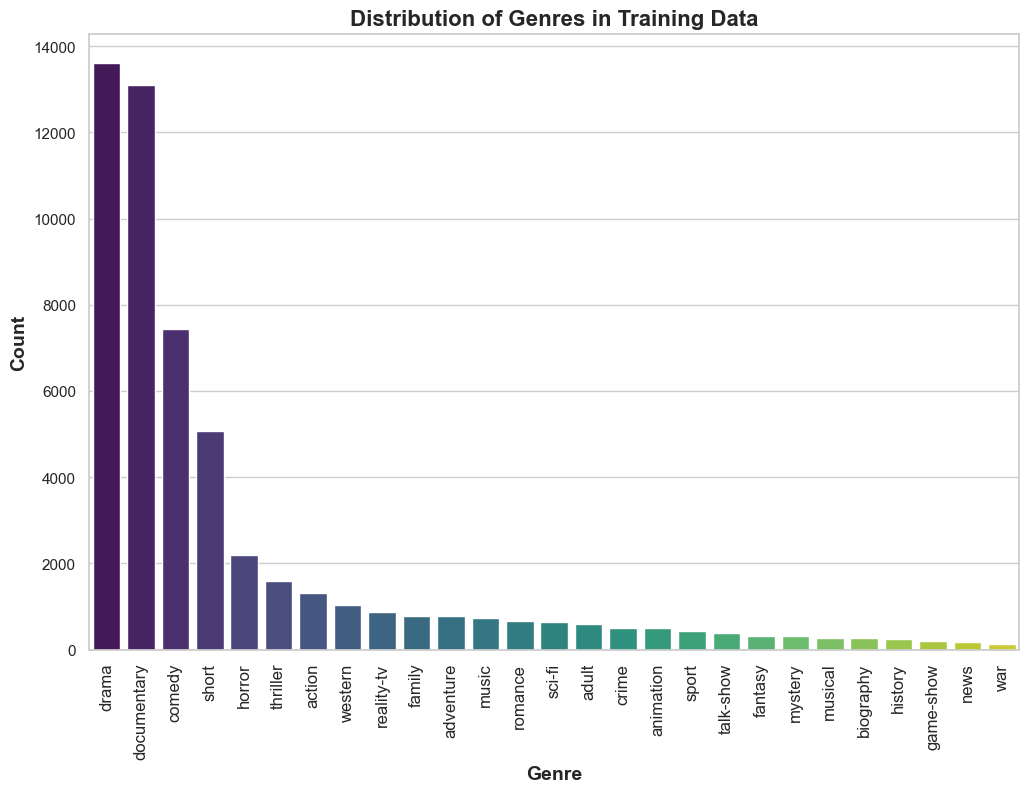

In [3]:
# Visualize Genre Distribution
plt.figure(figsize=(12, 8))
counts = df_train['GENRE'].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres in Training Data', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=12)
plt.show()

# Data Cleaning


In [4]:
# Initialize stemmer and stopwords
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans input text:
    1. Lowercase
    2. Remove URLs, handles, special chars
    3. Remove stopwords
    4. Stemming
    """
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\S+', '', text) # Remove mentions
    text = re.sub(r'#\S+', '', text) # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters/spaces
    
    # Tokenize & remove stopwords
    words = nltk.word_tokenize(text)
    words = [stemmer.stem(w) for w in words if w not in stop_words and len(w) > 2]
    
    return " ".join(words)

# Apply cleaning to descriptions
print("Cleaning training data...")
df_train['clean_desc'] = df_train['DESCRIPTION'].apply(clean_text)

print("Cleaning test data...")
df_test['clean_desc'] = df_test['DESCRIPTION'].apply(clean_text)

print("Data Preprocessing Complete.")

Cleaning training data...
Cleaning test data...
Data Preprocessing Complete.


# Feature Engineering & Stratified Split


In [5]:
# Initialize TF-IDF Vectorizer with N-grams (1,2)
# max_features=20000 ensures we capture a rich vocabulary
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1, 2), 
    stop_words='english'
)

print("Vectorizing data...")
# Fit on training data
X_train_full = tfidf_vectorizer.fit_transform(df_train['clean_desc'])
y_train_full = df_train['GENRE']

# Transform test data
X_test = tfidf_vectorizer.transform(df_test['clean_desc'])
y_test = df_test_sol['GENRE']

# Stratified Split (80% Train, 20% Validation)
print("Splitting data (Stratified)...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

Vectorizing data...
Splitting data (Stratified)...
Training Set: (43371, 20000)
Validation Set: (10843, 20000)


# Model Training (Grid Search)


In [6]:
# Define parameter grid for Linear SVC
param_grid = {'C': [0.1, 1, 10, 100]} 

# Initialize GridSearch with weighted F1-score as metric
print("Starting Hyperparameter Tuning (this may take a minute)...")
grid_search = GridSearchCV(
    LinearSVC(class_weight='balanced'), 
    param_grid, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1
)

# Train the model
grid_search.fit(X_train, y_train)

print("Best Parameters found:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Check Validation performance
y_val_pred = best_model.predict(X_val)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"Internal Validation Weighted F1 Score: {val_f1:.4f}")

Starting Hyperparameter Tuning (this may take a minute)...
Best Parameters found: {'C': 1}
Best Cross-Validation F1 Score: 0.5264652073396519
Internal Validation Weighted F1 Score: 0.5314


# Final Evaluation


Final Test Accuracy: 0.5197
Final Weighted F1 Score: 0.5292

Detailed Classification Report:
              precision    recall  f1-score   support

      action       0.31      0.44      0.36      1314
       adult       0.38      0.54      0.45       590
   adventure       0.22      0.28      0.25       775
   animation       0.16      0.21      0.18       498
   biography       0.05      0.05      0.05       264
      comedy       0.57      0.50      0.53      7446
       crime       0.13      0.18      0.15       505
 documentary       0.75      0.72      0.73     13096
       drama       0.65      0.50      0.57     13612
      family       0.18      0.26      0.21       783
     fantasy       0.14      0.19      0.16       322
   game-show       0.60      0.68      0.64       193
     history       0.08      0.09      0.08       243
      horror       0.52      0.67      0.58      2204
       music       0.44      0.65      0.52       731
     musical       0.13      0.17      0.1

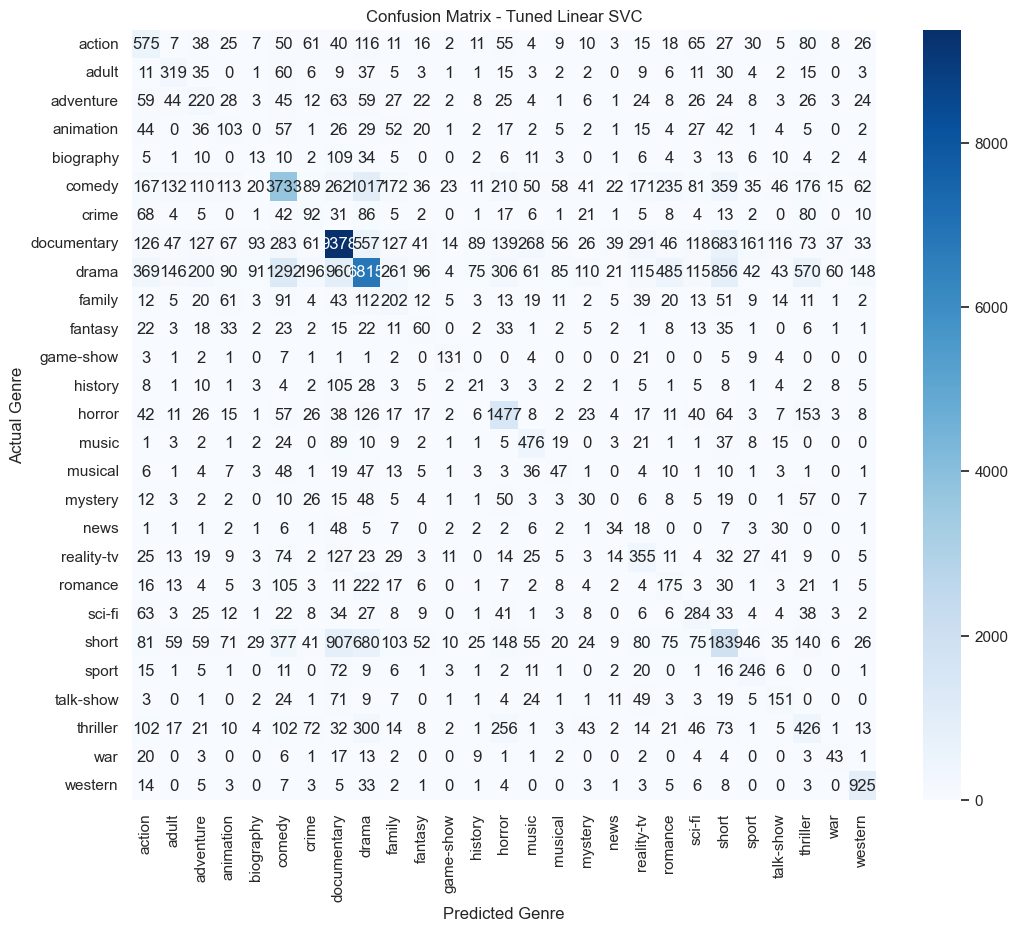

In [7]:
# Predict on Test Data
y_pred_final = best_model.predict(X_test)

# Calculate Metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, average='weighted')

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Final Weighted F1 Score: {final_f1:.4f}")

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
plt.figure(figsize=(12, 10))
conf_mat = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix - Tuned Linear SVC')
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.show()

# Deployment
We create a function to predict genres for new movie plots and save the model for deployment.

In [8]:
def predict_movie_genre(description):
    """
    Predicts the genre of a movie based on its description.
    """
    cleaned_desc = clean_text(description)
    X_input = tfidf_vectorizer.transform([cleaned_desc])
    predicted_label = best_model.predict(X_input)[0]
    return predicted_label

# Test on custom examples
sample_1 = "A group of explorers travel through a wormhole in space in an attempt to ensure humanity's survival."
sample_2 = "A young woman falls in love with a prince, but they are from different worlds."

print(f"Prediction for Sample 1: {predict_movie_genre(sample_1)}")
print(f"Prediction for Sample 2: {predict_movie_genre(sample_2)}")

# Save Model and Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('genre_classifier_svc.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("\nModel saved successfully!")

Prediction for Sample 1: sci-fi
Prediction for Sample 2: romance

Model saved successfully!


# Conclusion

In this project, I developed a Movie Genre Classification model using TF-IDF with N-grams (1,2) and a tuned Linear SVC.

After hyperparameter tuning (best C = 1), the model achieved:

- Final Test Accuracy: 0.5197 (~52%)
- Final Weighted F1-Score: 0.5292 (~0.53)

The model performed well on genres like documentary, drama, western, and comedy, but struggled with minority and closely related genres such as mystery, history, and musical.

Overall, the model demonstrates that text-based genre classification using machine learning is feasible, but performance is influenced by genre imbalance and overlapping themes.

# Future Scope

To further improve this project, I can:

- Use advanced models like Logistic Regression, Random Forest, or deep learning (LSTM/BERT).
- Apply class imbalance handling techniques such as SMOTE or better class weighting.
- Increase feature richness using higher N-grams or word embeddings (Word2Vec, GloVe).
- Perform more extensive hyperparameter tuning.
- Deploy the model as a web application using Flask or FastAPI.

With more advanced NLP techniques, the classification performance can be significantly improved.
